In [1]:
import os
import time
import glob
import shutil

import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.image as tfi
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D,  MaxPool2D, UpSampling2D, concatenate, Activation
from tensorflow.keras.layers import Layer, Input, Add, Multiply, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
def create_data(data_dir):
    image_paths = []
    mask_paths = []

    folds = sorted(os.listdir(data_dir))
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if fold in ['image', 'Image', 'images', 'Images', 'IMAGES']:
            images = sorted(os.listdir(foldpath))
            for image in images:
                fpath = os.path.join(foldpath, image)
                image_paths.append(fpath)

        elif fold in ['mask', 'Mask', 'masks', 'Masks', 'MASKS']:
            masks = sorted(os.listdir(foldpath))
            for mask in masks:
                fpath = os.path.join(foldpath, mask)
                mask_paths.append(fpath)
        else:
            continue

    return image_paths, mask_paths

In [3]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)

# function to read multiple images
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img

    return images

In [4]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

def show_images(imgs, msks):
    plt.figure(figsize=(13,8))

    for i in range(15):
        plt.subplot(3,5,i+1)
        id = np.random.randint(len(imgs))
        show_mask(imgs[id], msks[id], cmap='binary')

    plt.tight_layout()
    plt.show()

In [5]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

In [6]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

In [7]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [8]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")

print("Path to dataset files:", path)

100%|██████████| 107M/107M [00:02<00:00, 47.9MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1


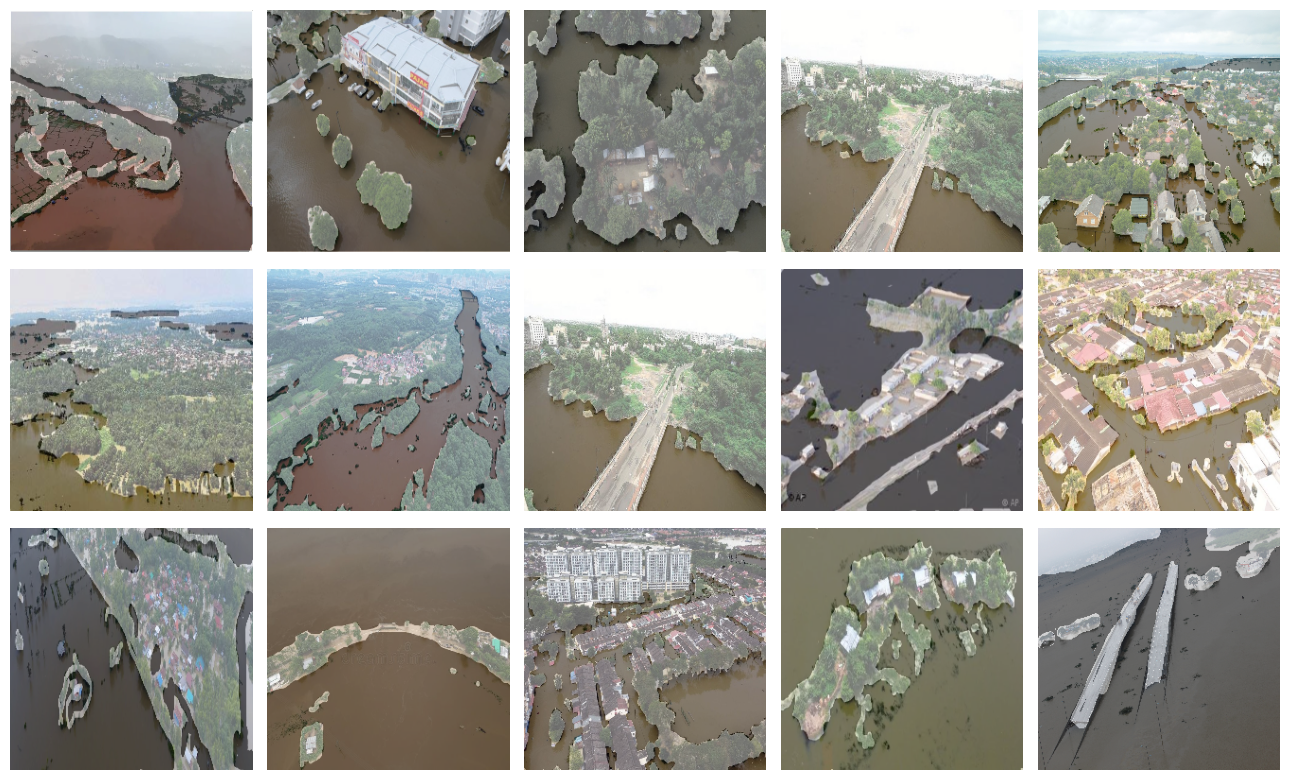

In [10]:
SIZE = 256

# get data
data_dir = '/root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1'
image_paths, mask_paths = create_data(data_dir)

# load images and masks
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)

# show sample
show_images(imgs, msks)

In [12]:
input_layer = Input(shape=imgs.shape[-3:])

p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)

encoding = EncoderBlock(512, 0.3, pooling=False, name="Encoding")(p4)

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256, 0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128, 0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64, 0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32, 0.1, name="Decoder4")([d3, a4])

output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs=10
steps_per_epoch=1
batch_size=32

subset_size = 0.2
subset_imgs = imgs[:int(len(imgs) * subset_size)]
subset_msks = msks[:int(len(msks) * subset_size)]

history = model.fit(
    subset_imgs, subset_msks,
    validation_split=0.2,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size
)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 115s 115s/step - accuracy: 0.3921 - loss: 1.3871 - val_accuracy: 0.6034 - val_loss: 0.9094
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 45s 45s/step - accuracy: 0.5229 - loss: 3.3596 - val_accuracy: 0.3660 - val_loss: 0.7191
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3660 - val_loss: 0.7191
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 142s 142s/step - accuracy: 0.4228 - loss: 0.8726 - val_accuracy: 0.3665 - val_loss: 0.7023
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - accuracy: 0.4401 - loss: 0.8026 - val_accuracy: 0.3675 - val_loss: 0.7008
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3675 - val_loss: 0.7008
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 148s 148s/step - accuracy: 0.4940 - loss: 0.7257 - val_accuracy: 0.3713 - val_loss: 0.6990
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - accuracy: 0.5559 - loss: 0.6851 - val_accuracy: 0.3831 -

In [13]:
# Assuming imgs and msks are your full dataset
input_layer = Input(shape=imgs.shape[-3:])

# Encoder blocks
p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)

# Bridge
encoding = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
encoding = Dropout(0.3)(encoding)
encoding = Conv2D(512, (3, 3), activation='relu', padding='same')(encoding)

# Attention gates and decoder blocks
a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256, 0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128, 0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64, 0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32, 0.1, name="Decoder4")([d3, a4])

# Output layer
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Define the model
model = Model(input_layer, output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with all images and masks
history = model.fit(
    imgs, msks,       # Use the full dataset instead of a subset
    validation_split=0.2,  # Still reserve 20% for validation
    epochs=10,        # You can increase epochs if needed
    verbose=1,
    batch_size=32     # You can adjust the batch size according to your GPU/CPU capacity
)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 674s 82s/step - accuracy: 0.5616 - loss: 3.8541 - val_accuracy: 0.4212 - val_loss: 0.6908
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 679s 81s/step - accuracy: 0.7191 - loss: 0.5417 - val_accuracy: 0.3806 - val_loss: 0.7119
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 659s 82s/step - accuracy: 0.7477 - loss: 0.5000 - val_accuracy: 0.4904 - val_loss: 0.6836
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 682s 82s/step - accuracy: 0.7851 - loss: 0.4566 - val_accuracy: 0.5326 - val_loss: 0.6755
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 723s 88s/step - accuracy: 0.8021 - loss: 0.4215 - val_accuracy: 0.5793 - val_loss: 0.6557
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 698s 82s/step - accuracy: 0.8043 - loss: 0.4158 - val_accuracy: 0.5766 - val_loss: 0.6583
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 681s 82s/step - accuracy: 0.8164 - loss: 0.3904 - val_accuracy: 0.6503 - val_loss: 0.6328
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 680s 81s/step - accuracy: 0.8207 - loss: 0.3861 - val_accuracy: 0.6273 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


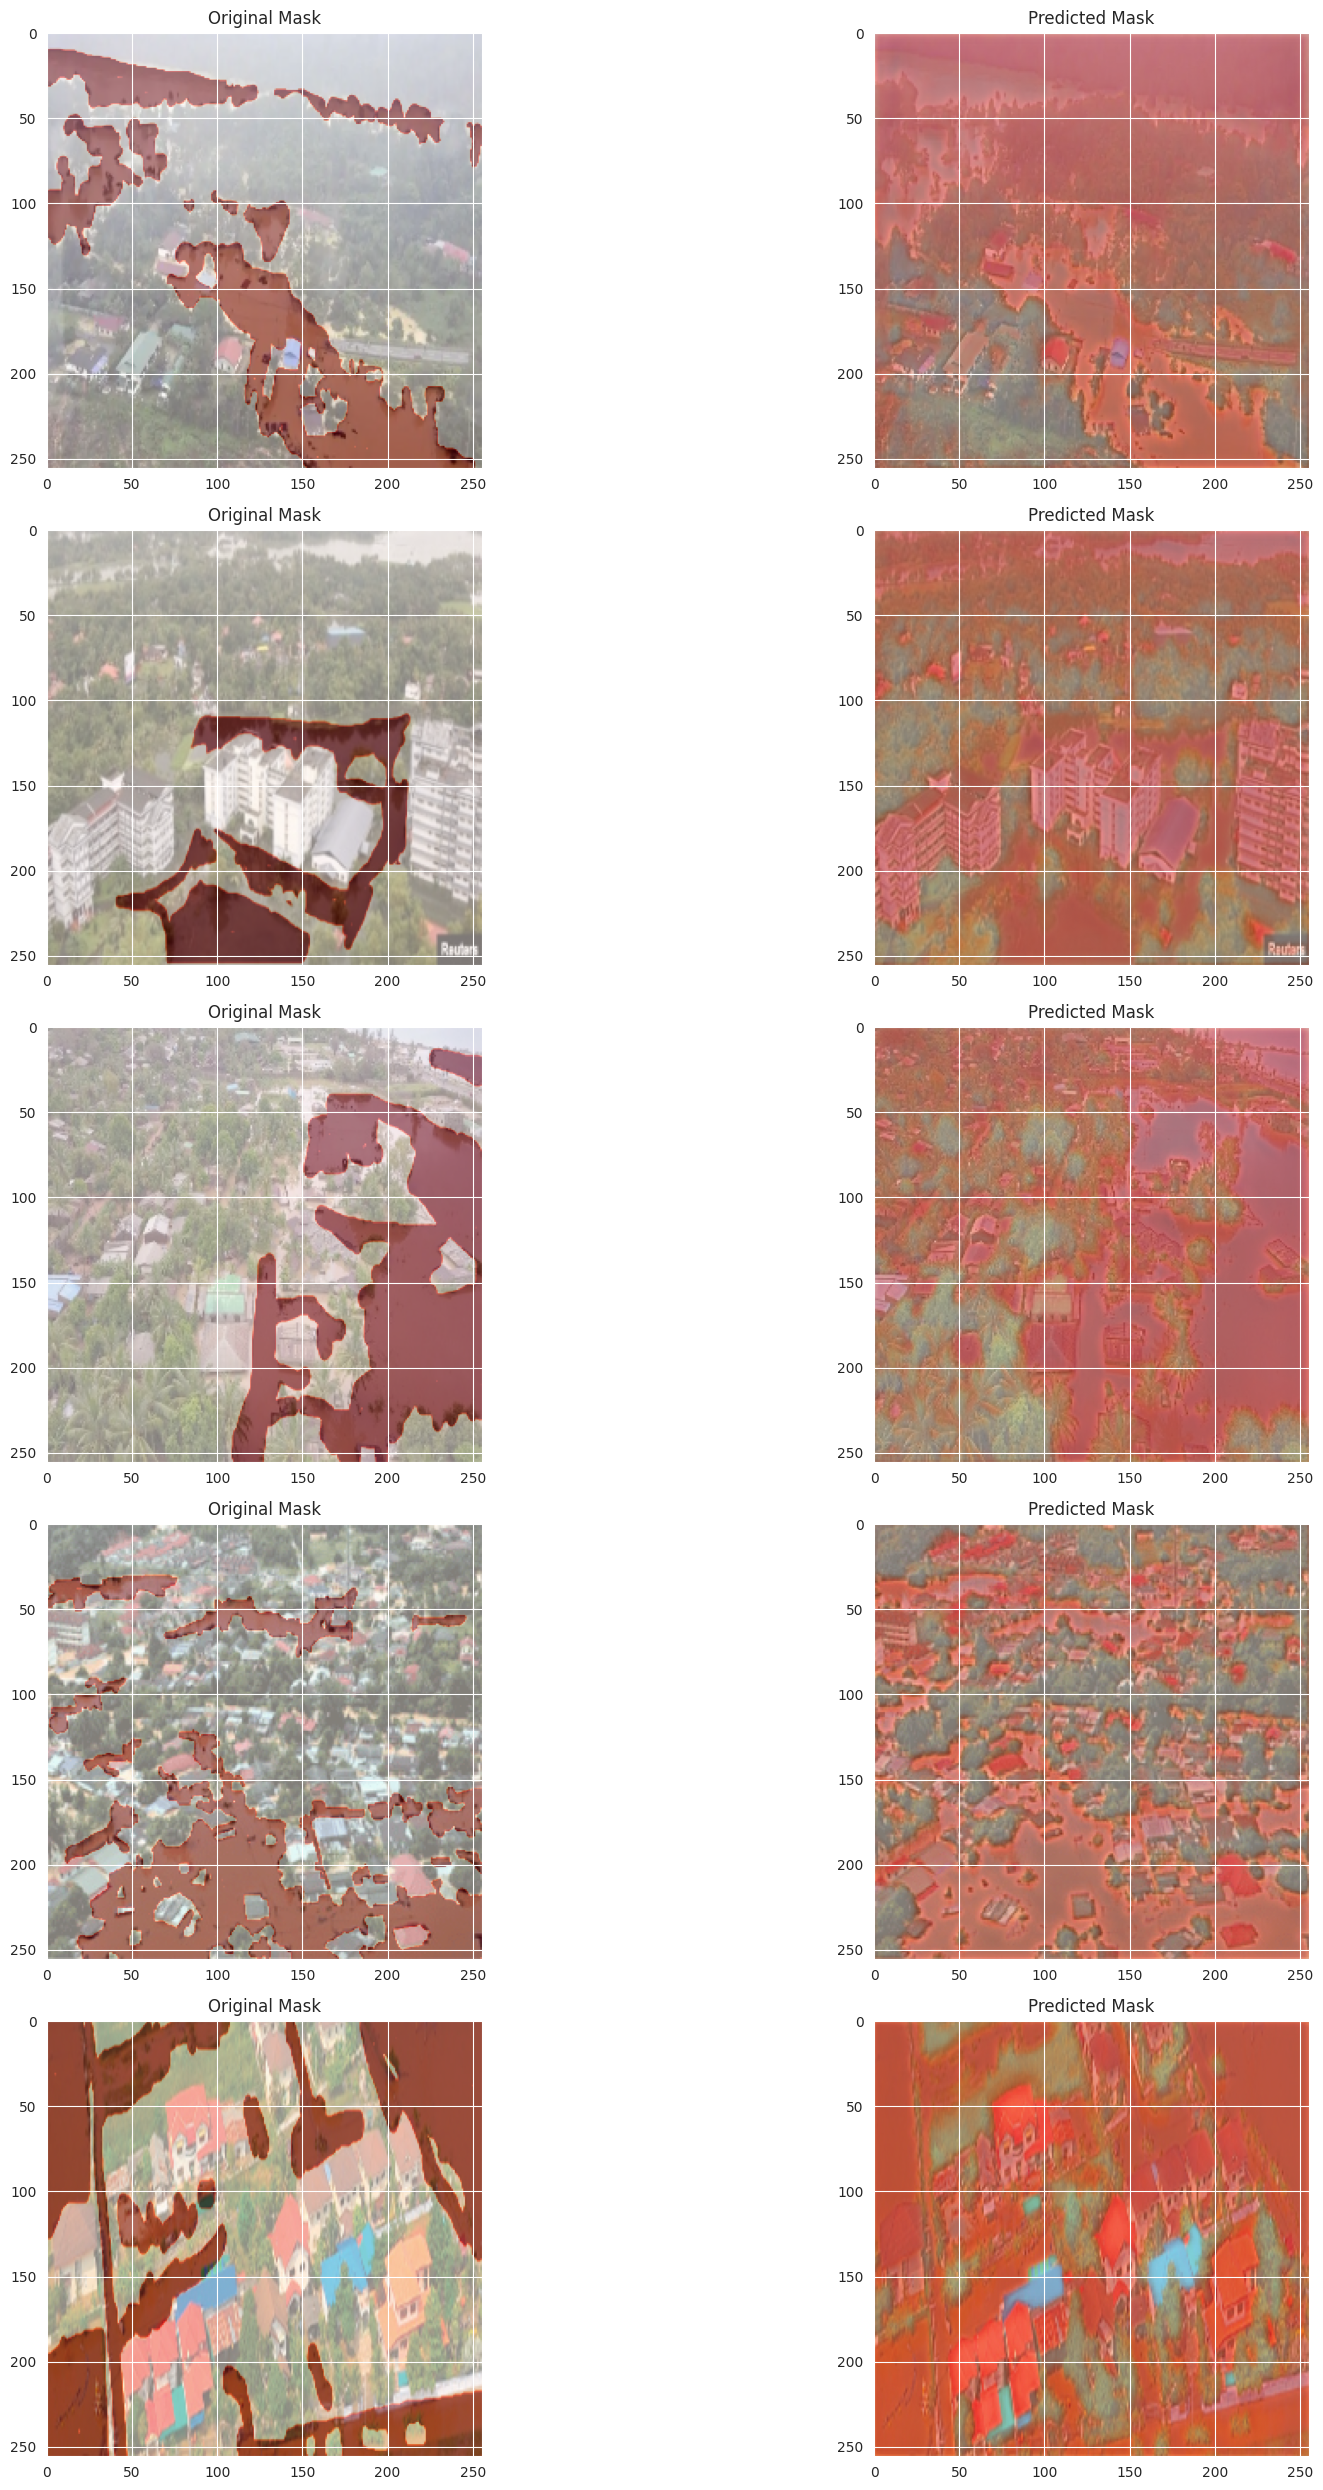

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(image, mask):
    plt.imshow(image)  # Show image in the background
    plt.imshow(mask, alpha=0.5, cmap='Reds')  # Overlay mask with transparency

# Plot original and predicted masks
plt.figure(figsize=(20, 25))
n = 0

for i in range(1, (5 * 2) + 1):  # Adjusted to plot only 2 masks
    plt.subplot(5, 2, i)

    if n == 0:
        # Select a random image and mask
        id = np.random.randint(len(imgs))
        image = imgs[id]
        mask = msks[id]

        # Predict the mask for the selected image
        pred_mask = model.predict(image[np.newaxis, ...])

        # Plot original mask
        plt.title("Original Mask")
        show_mask(image, mask)
        n += 1

    elif n == 1:
        # Plot predicted mask
        plt.title("Predicted Mask")
        show_mask(image, pred_mask.squeeze())  # Squeeze to remove extra dimensions
        n = 0

plt.tight_layout()
plt.show()

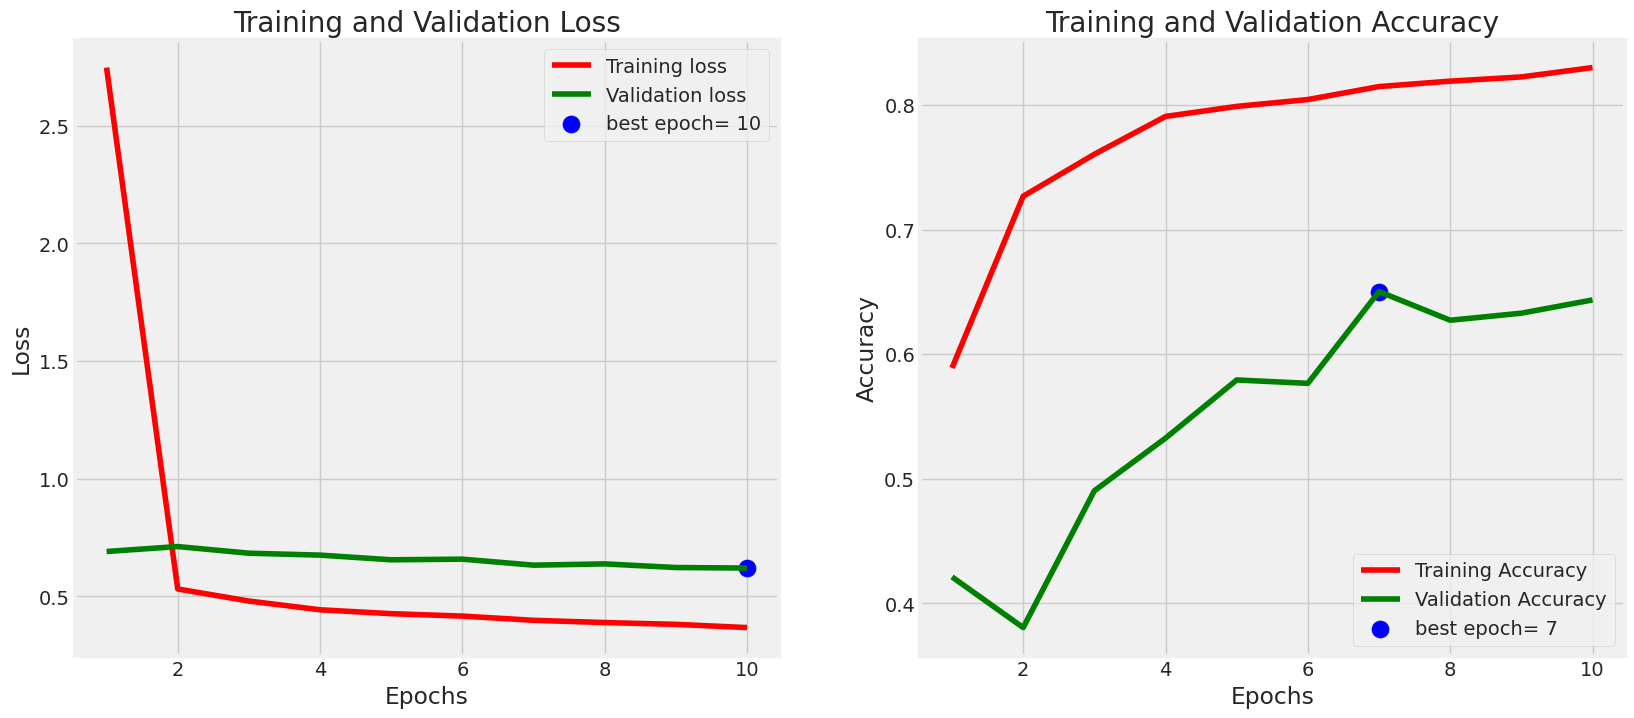

In [15]:
plot_training(history)